In [1]:
import tensorflow as tf
import keras
import os
import pathlib
import time
import datetime
import matplotlib.pyplot as plt
tf.keras.mixed_precision.set_global_policy("mixed_float16")
from tqdm import tqdm
from src.models import *
from src.utils import TFUtils

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
utils = TFUtils(vgg = True)

In [5]:
BATCH_SIZE = 4
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
STEPS = 10000
load = True
vgg = False
# Create the data generators
# Create the generator and discriminator
utils = TFUtils(vgg)
train_generator, validation_generator = utils.create_datagenerators(
    IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE
)
if vgg:
    generator = VGG19Generator()
    discriminator = VGG19Discriminator()
else:
    generator = Generator()
    discriminator = Discriminator()

# Create the optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.6)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.6)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gan = GAN(generator, discriminator)
gan.compile(generator_optimizer, discriminator_optimizer,loss_object)

os.makedirs("logs", exist_ok=True)
os.makedirs("training_checkpoints", exist_ok=True)
# Create the checkpoint directory
if load:
    try:
        time_now = os.listdir('training_checkpoints')[-1]
        latest = tf.train.latest_checkpoint(os.path.join('training_checkpoints', time_now))
        gan.load_weights(latest)
    except IndexError:
        print("No checkpoints found. Training from scratch")
        time_now = str(datetime.datetime.now().strftime("%Y%m%d-%H%M"))
else:
    time_now = str(datetime.datetime.now().strftime("%Y%m%d-%H%M"))

log_dir = os.path.join("logs", time_now)
ckpt_dir = os.path.join("./training_checkpoints",str(datetime.datetime.now().strftime("%Y%m%d-%H%M")), "ckpt")
print("New model will be saved to: ", ckpt_dir)
checkpoint_prefix = ckpt_dir


Found 420 images belonging to 1 classes.
Found 420 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
New model will be saved to:  ./training_checkpoints\20230420-1439\ckpt


In [6]:
example_input, example_target = next(iter(validation_generator))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor = 'g_loss',
    mode = 'min',
    save_best_only=True,
    save_weights_only=True,)
    
tf_summary = tf.summary.create_file_writer(os.path.join(log_dir,'images'))

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      write_graph=False,
                                                      profile_batch=(100,120))

es_callback = tf.keras.callbacks.EarlyStopping(monitor='gen_gan_loss', mode='min', verbose=1, patience=100)

terminate_callback = tf.keras.callbacks.TerminateOnNaN()

In [7]:
import tracemalloc
tracemalloc.start()
NUM_RUNS = 10
from IPython.display import clear_output
start = time.time()
for i in range(NUM_RUNS):
    if i != 0:
        print(f"Time taken for epoch: {(time.time() - start)/60:2f} mins")
        start = time.time()
    print(f"Run: {i} / {NUM_RUNS}")
    gan.fit(
        train_generator,
        epochs=10,
        verbose=1,
        steps_per_epoch=100,
        use_multiprocessing=True,
        callbacks=[checkpoint_callback, 
        tensorboard_callback, 
        es_callback,
        terminate_callback],
    )
    utils.generate_images_tensorboard(gan, example_input, example_target, tf_summary, i)
    clear_output(wait=True)

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

[ Top 10 ]
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py:432: size=1394 KiB, count=8501, average=168 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py:2065: size=877 KiB, count=7744, average=116 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\abc.py:123: size=398 KiB, count=5590, average=73 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\linecache.py:137: size=390 KiB, count=3743, average=107 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py:2131: size=350 KiB, count=3872, average=93 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py:423: size=328 KiB, count=5104, average=66 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\c_api_util.py:229: size=248 KiB, count=4536, average=56 B
c:\Users\wayne\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py:5363: size=242 KiB, count=

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [18]:
utils.generate_images_tensorboard(gan, example_input, example_target, tf_summary, 0)

<Figure size 1500x1500 with 0 Axes>

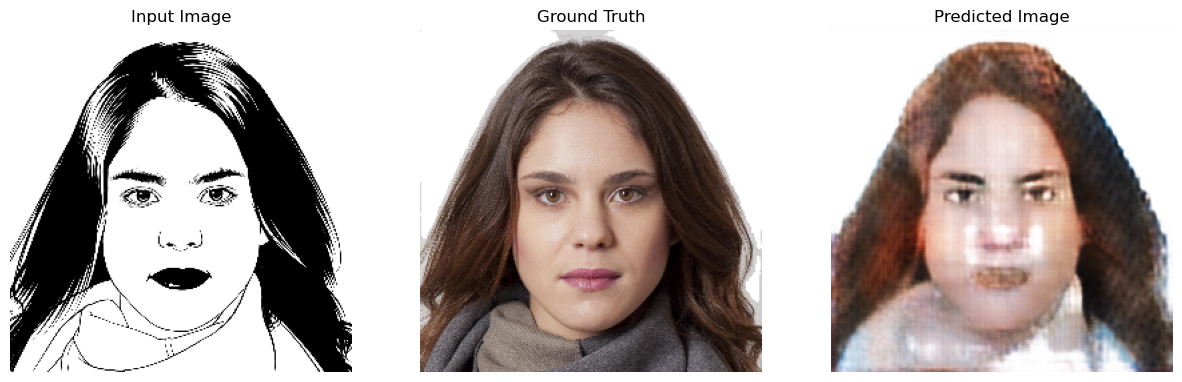

In [19]:
example_input, example_target = next(iter(validation_generator))
utils.generate_images(generator, example_input, example_target)